<a href="https://colab.research.google.com/github/OlhaYastrebova/goit-ds-hw/blob/main/Hw_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [3]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, input_size, name=None):
        super().__init__(name=name)
        # Перший шар - 128 нейронів
        self.layer1 = DenseLayer(in_features=input_size, out_features=128)
        # Другий шар - 256 нейронів
        self.layer2 = DenseLayer(in_features=128, out_features=256)
        # Вихідний шар - 10 нейронів
        self.output_layer = DenseLayer(in_features=256, out_features=10)


  def __call__(self, x):
        # Пропускаємо вхід через перший шар
        x = self.layer1(x)
        # Пропускаємо через другий шар
        x = self.layer2(x)
        # Вихідний шар з softmax для класифікації
        return self.output_layer(x, activation=1)

In [11]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Знаходимо індекс класу з найбільшою ймовірністю для передбачень
    predicted_classes = tf.argmax(y_pred, axis=1)

    # Приводимо y_true до того ж типу, що і predicted_classes (int64)
    y_true = tf.cast(y_true, tf.int64)

    # Порівнюємо з індексами справжніх класів
    correct_predictions = tf.equal(predicted_classes, y_true)

    # Обчислюємо точність
    return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))


In [12]:
# Кількість вхідних ознак для MNIST (28x28 = 784 пікселів)
input_size = 784

# Створюємо екземпляр нейронної мережі
neural_net = NN(input_size=input_size, name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y, learning_rate=0.01):
    # Оптимізатор - стохастичний градієнтний спуск
    optimizer = tf.optimizers.SGD(learning_rate)

    # Активація автоматичного диференціювання
    with tf.GradientTape() as g:
        # Передбачення за допомогою нейронної мережі
        pred = neural_net(input_x)

        # Обчислення функції втрат
        loss = cross_entropy(pred, output_y)

    # Отримуємо список параметрів нейронної мережі (ваги і зсуви всіх шарів)
    trainable_variables = [neural_net.layer1.w, neural_net.layer1.b,
                           neural_net.layer2.w, neural_net.layer2.b,
                           neural_net.output_layer.w, neural_net.output_layer.b]

    # Обчислюємо градієнти для цих параметрів
    gradients = g.gradient(loss, trainable_variables)

    # Оновлюємо параметри за допомогою оптимізатора
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss

In [13]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    loss = train(neural_net, batch_x, batch_y, learning_rate)

    # Кожні display_step кроків обчислюємо поточну точність і втрату
    if step % display_step == 0:
        pred = neural_net(batch_x)

        # Обчислення функції втрат
        current_loss = cross_entropy(pred, batch_y)

        # Обчислення точності
        current_accuracy = accuracy(pred, batch_y)

        # Зберігаємо значення у відповідні списки
        loss_history.append(current_loss.numpy())
        accuracy_history.append(current_accuracy.numpy())

        # Виводимо поточну інформацію
        print(f"Step {step}, Loss: {current_loss.numpy()}, Accuracy: {current_accuracy.numpy()}")


Step 100, Loss: 692.4364013671875, Accuracy: 0.62109375
Step 200, Loss: 630.36181640625, Accuracy: 0.73828125
Step 300, Loss: 566.4074096679688, Accuracy: 0.72265625
Step 400, Loss: 656.9197998046875, Accuracy: 0.7734375
Step 500, Loss: 441.6822509765625, Accuracy: 0.796875
Step 600, Loss: 571.561767578125, Accuracy: 0.79296875
Step 700, Loss: 635.2816772460938, Accuracy: 0.7890625
Step 800, Loss: 726.9847412109375, Accuracy: 0.7578125
Step 900, Loss: 697.5797729492188, Accuracy: 0.77734375
Step 1000, Loss: 605.1416015625, Accuracy: 0.8359375
Step 1100, Loss: 542.8580322265625, Accuracy: 0.83203125
Step 1200, Loss: 660.7145385742188, Accuracy: 0.76953125
Step 1300, Loss: 724.5292358398438, Accuracy: 0.8046875
Step 1400, Loss: 607.9501342773438, Accuracy: 0.8359375
Step 1500, Loss: 561.2554321289062, Accuracy: 0.78515625
Step 1600, Loss: 551.8092041015625, Accuracy: 0.80859375
Step 1700, Loss: 632.0184326171875, Accuracy: 0.82421875
Step 1800, Loss: 612.3875732421875, Accuracy: 0.820312

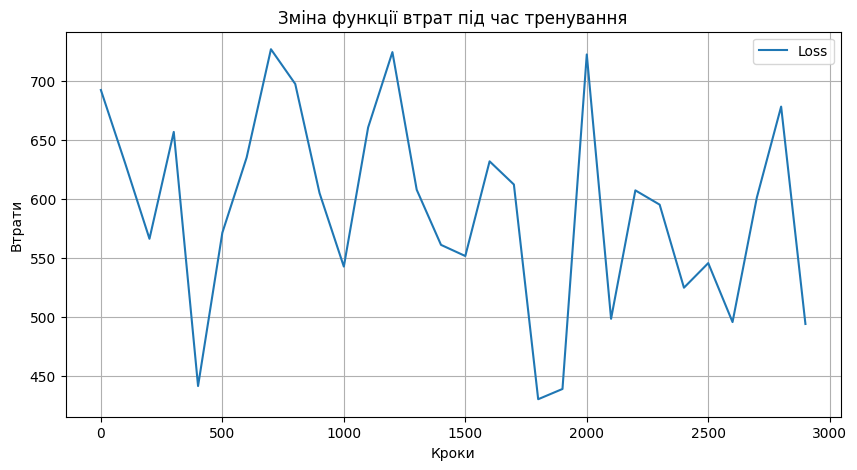

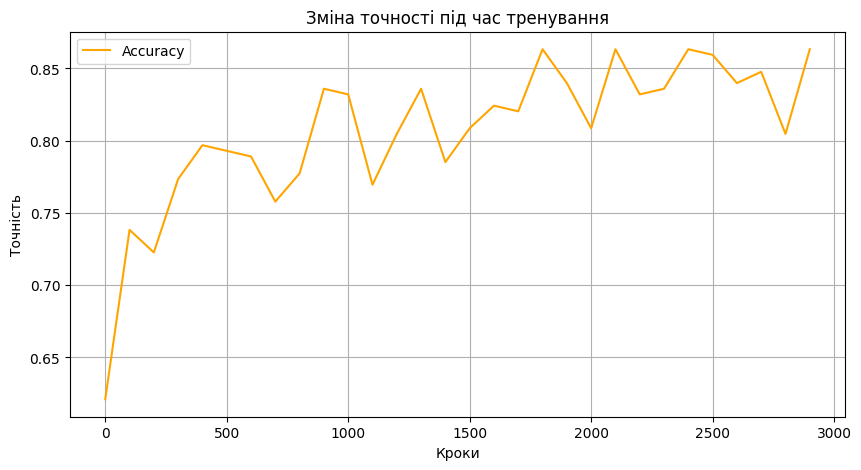

In [14]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Графік функції втрат
plt.figure(figsize=(10, 5))
plt.plot(range(0, training_steps, display_step), loss_history, label="Loss")
plt.title("Зміна функції втрат під час тренування")
plt.xlabel("Кроки")
plt.ylabel("Втрати")
plt.grid(True)
plt.legend()
plt.show()

# Графік точності
plt.figure(figsize=(10, 5))
plt.plot(range(0, training_steps, display_step), accuracy_history, label="Accuracy", color='orange')
plt.title("Зміна точності під час тренування")
plt.xlabel("Кроки")
plt.ylabel("Точність")
plt.grid(True)
plt.legend()
plt.show()


In [17]:
# Завантажимо датасет MNIST
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Перетворюємо зображення на 1D масиви та нормалізуємо
test_images = test_images.reshape(-1, 784).astype('float32') / 255.0

# Створюємо TensorFlow Dataset
test_data = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(32)

# Обчисліть точність навченої нейромережі
# Обчислимо точність на тестовому наборі
total_accuracy = 0
num_batches = 0

for batch_x, batch_y in test_data:
    # Отримуємо передбачення
    pred = neural_net(batch_x)

    # Обчислюємо точність для поточного батчу
    batch_accuracy = accuracy(pred, batch_y)
    total_accuracy += batch_accuracy
    num_batches += 1

# Обчислимо середню точність по всіх батчах
total_accuracy /= num_batches
print(f"Точність на тестовому наборі даних: {total_accuracy.numpy()}")

Точність на тестовому наборі даних: 0.8213858008384705


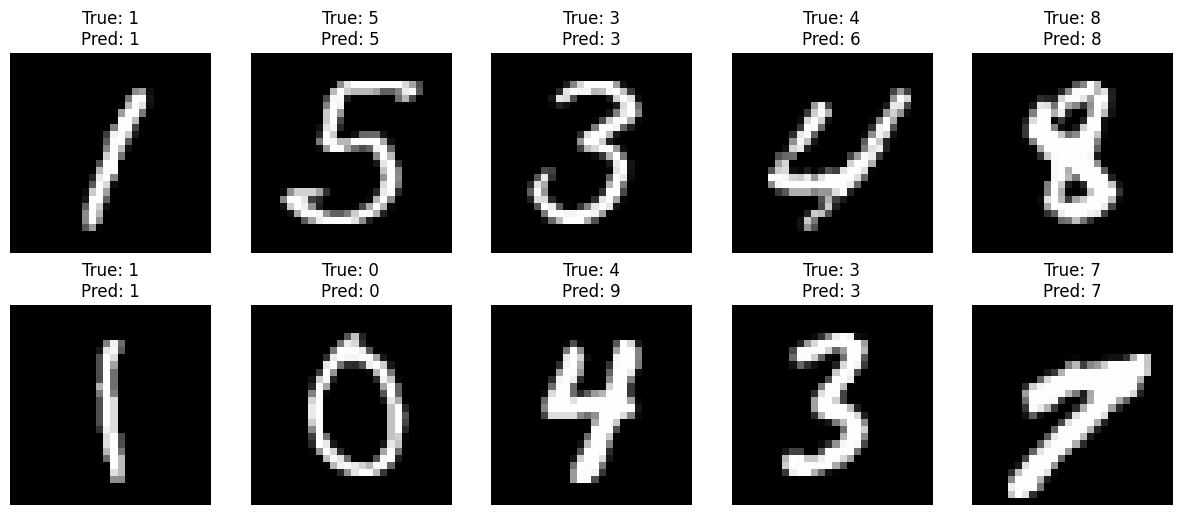

In [24]:
# Протестуйте навчену нейромережу на 10 зображеннях.
# Вибираємо 10 випадкових зображень з тестового набору
num_samples = 10
random_indices = np.random.choice(len(test_images), num_samples, replace=False)
random_images = test_images[random_indices]
random_labels = test_labels[random_indices]

# Прогоняємо вибрані зображення через нейронну мережу
predictions = neural_net(random_images)

# Отримуємо передбачення для кожного зображення
predicted_classes = np.argmax(predictions, axis=1)

# Виводимо зображення та відповідні передбачення
plt.figure(figsize=(15, 6))
for i in range(num_samples):
    plt.subplot(2, 5, i + 1)
    plt.imshow(random_images[i].reshape(28, 28), cmap='gray')
    plt.title(f"True: {random_labels[i]}\nPred: {predicted_classes[i]}")
    plt.axis('off')
plt.show()

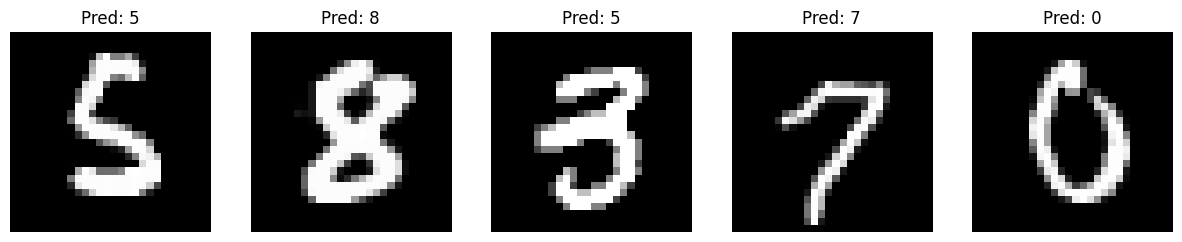

Кількість правильних передбачень: 4/5
Частота помилок: 20.00%


In [19]:
#З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

# Вибираємо 5 випадкових зображень з тестового набору
num_samples = 5
random_indices = np.random.choice(len(test_images), num_samples, replace=False)
random_images = test_images[random_indices]
random_labels = test_labels[random_indices]

# Прогоняємо випадкові зображення через нейронну мережу
predictions = neural_net(random_images)

# Отримуємо передбачення для кожного зображення
predicted_classes = np.argmax(predictions, axis=1)

# Виводимо зображення та відповідні передбачення
plt.figure(figsize=(15, 6))
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(random_images[i].reshape(28, 28), cmap='gray')
    plt.title(f"Pred: {predicted_classes[i]}")
    plt.axis('off')
plt.show()

# Порівнюємо передбачення з справжніми мітками
correct_predictions = np.sum(predicted_classes == random_labels)
total_samples = len(random_labels)
error_rate = 1 - (correct_predictions / total_samples)

print(f"Кількість правильних передбачень: {correct_predictions}/{total_samples}")
print(f"Частота помилок: {error_rate * 100:.2f}%")


Виведіть метрики якості для кожного класу навченої моделі, використовуючи https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

In [23]:
from sklearn.metrics import classification_report

# Прогоняємо весь тестовий набір через нейронну мережу
all_predictions = []
all_labels = []

for batch_x, batch_y in test_data:
    pred = neural_net(batch_x)
    predicted_classes = np.argmax(pred, axis=1)

    all_predictions.extend(predicted_classes)
    all_labels.extend(batch_y.numpy())

# Генеруємо звіт з метриками якості
report = classification_report(
    all_labels,
    all_predictions,
    digits=4,
    target_names=[str(i) for i in range(num_classes)],
    zero_division=0  # Задаємо значення для precision, recall, F-score, коли не було передбачень
)

print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0     0.9351    0.9551    0.9450       980
           1     0.9709    0.9709    0.9709      1135
           2     0.8520    0.8983    0.8745      1032
           3     0.8570    0.8842    0.8704      1010
           4     0.0000    0.0000    0.0000       982
           5     0.8701    0.8487    0.8593       892
           6     0.8708    0.9499    0.9086       958
           7     0.8892    0.9056    0.8973      1028
           8     0.8095    0.8593    0.8337       974
           9     0.5299    0.9128    0.6705      1009

    accuracy                         0.8214     10000
   macro avg     0.7585    0.8185    0.7830     10000
weighted avg     0.7611    0.8214    0.7858     10000



Зробити висновки.

Аналіз Результатів

Клас 4: Модель не класифікує жодне зображення цього класу (precision, recall і F1-score всі нульові). Це може бути ознакою того, що або даних для цього класу недостатньо, або модель не навчена добре для розпізнавання цього класу.

Клас 9: Має найгірші показники точності (0.5299), хоча повнота є досить високою (0.9128). Це свідчить про те, що модель добре знаходить цей клас, але часто помиляється в класифікації.

Інші класи: Більшість класів має високу точність і повноту, з F1-мірою, що перевищує 0.80, що свідчить про хорошу якість моделі для цих класів.

Макро середня (Macro avg): Обчислює середні значення метрик без врахування підтримки (кількість зразків у кожному класі). Це допомагає оцінити загальну ефективність моделі, якщо класи мають різну кількість зразків.

Вагова середня (Weighted avg): Враховує підтримку кожного класу при обчисленні середніх метрик, що дає уявлення про загальну ефективність моделі з урахуванням нерівномірного розподілу класів.

Висновки
Слабкі місця: Клас 4 потребує особливої уваги, оскільки модель не може його розпізнати. Може знадобитися покращення якості даних або модифікація моделі.

Покращення: Може бути корисним провести додаткове навчання або налаштування для підвищення точності та повноти, особливо для класів, де модель показує слабкі результати.

Загальна ефективність: Модель демонструє добрі загальні результати, з високою точністю та повнотою для більшості класів, але є простір для поліпшення для деяких специфічних класів.